In [1]:
import sys

sys.path.append('../..')
import torchdyn; from torchdyn.models import *; from torchdyn.datasets import *
from pytorch_lightning.loggers import WandbLogger

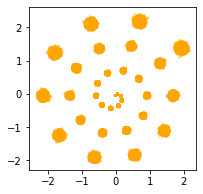

In [2]:
data = ToyDataset()
n_samples = 1 << 16
n_gaussians = 7

X, yn = data.generate(n_samples // n_gaussians, 'gaussians_spiral', n_gaussians=32, n_gaussians_per_loop=10, std_gaussians_start=0.5, std_gaussians_end=0.01, 
                      dim=2, radius_start=20, radius_end=0.1)
X = (X - X.mean())/X.std()

import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
plt.scatter(X[:,0], X[:,1], c='orange', alpha=0.3, s=4)

In [3]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn).long().to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=512, shuffle=True) 

## Model

In [4]:
import torch
import torch.nn as nn

def autograd_trace(x_out, x_in, **kwargs):
    """Standard brute-force means of obtaining trace of the Jacobian, O(d) calls to autograd"""
    trJ = 0.
    for i in range(x_in.shape[1]):
        trJ += torch.autograd.grad(x_out[:, i].sum(), x_in, allow_unused=False, create_graph=True)[0][:, i]  
    return trJ

def hutch_trace(x_out, x_in, noise=None, **kwargs):
    """Hutchinson's trace Jacobian estimator, O(1) call to autograd"""
    jvp = torch.autograd.grad(x_out, x_in, noise, create_graph=True)[0]
    trJ = torch.einsum('bi,bi->b', jvp, noise)
    
    return trJ

REQUIRES_NOISE = [hutch_trace]

class CNF(nn.Module):
    def __init__(self, net, trace_estimator=None, noise_dist=None, order=1):
        super().__init__()
        self.net, self.order = net, order # order at the CNF level will be merged with DEFunc
        self.trace_estimator = trace_estimator if trace_estimator is not None else autograd_trace;
        self.noise_dist, self.noise = noise_dist, None
        if self.trace_estimator in REQUIRES_NOISE:
            assert self.noise_dist is not None, 'This type of trace estimator requires specification of a noise distribution'
            
    def forward(self, x):   
        with torch.set_grad_enabled(True):
            x_in = torch.autograd.Variable(x[:,1:], requires_grad=True).to(x) # first dimension reserved to divergence propagation
            
            # the neural network will handle the data-dynamics here
            if self.order > 1: x_out = self.higher_order(x_in)
            else: x_out = self.net(x_in)
                
            trJ = self.trace_estimator(x_out, x_in, noise=self.noise)
        return torch.cat([-trJ[:, None], x_out], 1) + 0*x # `+ 0*x` has the only purpose of connecting x[:, 0] to autograd graph
    
    def higher_order(self, x):
        # NOTE: higher-order in CNF is handled at the CNF level, to refactor
        x_new = []
        size_order = x.size(1) // self.order
        for i in range(1, self.order):
            x_new += [x[:, size_order*i:size_order*(i+1)]]
        x_new += [self.net(x)]
        return torch.cat(x_new, 1).to(x)

In [11]:
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform, Categorical
prior = MultivariateNormal(torch.zeros(2).to(device), 2*torch.eye(2).to(device))

ndes = []
for i in range(1):
    
    f = nn.Sequential(
            nn.Linear(2, 64),
            nn.Softplus(),
            nn.Linear(64, 64),
            nn.Softplus(),
            nn.Linear(64, 64),
            nn.Softplus(),
            nn.Linear(64, 64),
            nn.Softplus(),
            nn.Linear(64, 64),
            nn.Softplus(),
            nn.Linear(64, 64),
            nn.Softplus(),
            nn.Linear(64, 64),
            nn.Softplus(),
            nn.Linear(64, 2),
        
        )

    
    cnf = CNF(f, order=1) # for CNFs, order is specified here instead of `NeuralDE`
    
    nde = NeuralDE(cnf, solver='dopri5', s_span=torch.linspace(0, 1, 2), atol=1e-6, rtol=1e-6, sensitivity='adjoint')
    ndes.append(nde)


model = nn.Sequential(Augmenter(augment_idx=1, augment_dims=1),
                      *ndes).to(device)

## Learner

In [12]:
def cnf_density(model, npts=100, memory= 100):
    with torch.no_grad():
        side = np.linspace(-2., 2., npts)
        xx, yy = np.meshgrid(side, side)
        x = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])
        x = torch.from_numpy(x).type(torch.float32).to(device)

        z, delta_logp = [], []
        inds = torch.arange(0, x.shape[0]).to(torch.int64)
        for ii in torch.split(inds, int(memory**2)):
            z_full = model(x[ii]).cpu().detach()
            z_, delta_logp_ = z_full[:, 1:3], z_full[:, 0]
            z.append(z_)
            delta_logp.append(delta_logp_)

        z = torch.cat(z, 0)
        delta_logp = torch.cat(delta_logp, 0)

        logpz = prior.log_prob(z.cuda()).cpu() # logp(z)
        logpx = logpz - delta_logp
        px = np.exp(logpx.cpu().numpy()).reshape(npts, npts)
        plt.figure(figsize=(32, 32))
        plt.imshow(px);

In [14]:
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.lr = 3e-3
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        # plot logging  
        if batch_idx % 50 == 0: 
            plot_samples()
            self.logger.experiment.log({"chart": plt})
            plt.close()
            nde.nfe = 0
        
        x, _ = batch     
        xtrJ = self.model(x)  
        logprob = prior.log_prob(xtrJ[:,1:3]).to(x) - xtrJ[:,0] 
        loss = -torch.mean(logprob)
        
        nfe = nde.nfe
        nde.nfe = 0
        
        metrics = {'loss': loss, 'nfe':nfe}
        self.logger.experiment.log(metrics) 
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-5)

    def train_dataloader(self):
        self.loader_l = len(trainloader)
        return trainloader

In [15]:
logger = WandbLogger(project='torchdyn-toy_cnf-bench-spiral')
learn = Learner(model)
trainer = pl.Trainer(min_steps=45000, max_steps=45000, gpus=1, logger=logger)
trainer.fit(learn);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


wandb: Wandb version 0.9.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 25 K  
/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning:

The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



In [16]:
sample = prior.sample(torch.Size([1<<15]))
# integrating from 1 to 0, 8 steps of rk4
model[1].s_span = torch.linspace(1, 0, 2)
new_x = model(sample).cpu().detach()

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 11.91 GiB total capacity; 147.48 MiB already allocated; 14.56 MiB free; 194.00 MiB reserved in total by PyTorch) (malloc at /pytorch/c10/cuda/CUDACachingAllocator.cpp:289)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x46 (0x7f7c381d5536 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x1cf1e (0x7f7c3841ef1e in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x1df9e (0x7f7c3841ff9e in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #3: at::native::empty_cuda(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x135 (0x7f7be375c535 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #4: <unknown function> + 0xf7a66b (0x7f7be1d5466b in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0xfc3f57 (0x7f7be1d9df57 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #6: <unknown function> + 0x1075389 (0x7f7c1e2d9389 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #7: <unknown function> + 0x10756c7 (0x7f7c1e2d96c7 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0xe3c42e (0x7f7c1e0a042e in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #9: at::TensorIterator::fast_set_up() + 0x5cf (0x7f7c1e0a12af in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #10: at::TensorIterator::build() + 0x4c (0x7f7c1e0a1b6c in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #11: at::TensorIterator::binary_op(at::Tensor&, at::Tensor const&, at::Tensor const&, bool) + 0x146 (0x7f7c1e0a2216 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #12: at::native::softplus_backward(at::Tensor const&, at::Tensor const&, c10::Scalar, c10::Scalar, at::Tensor const&) + 0x37 (0x7f7c1dd5a667 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #13: <unknown function> + 0x117e067 (0x7f7c1e3e2067 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #14: <unknown function> + 0x1189a6e (0x7f7c1e3eda6e in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #15: <unknown function> + 0x2c086ef (0x7f7c1fe6c6ef in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #16: <unknown function> + 0x1189a6e (0x7f7c1e3eda6e in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #17: torch::autograd::generated::SoftplusBackward::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0x306 (0x7f7c1fb154a6 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #18: <unknown function> + 0x2d89c05 (0x7f7c1ffedc05 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #19: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&) + 0x16f3 (0x7f7c1ffeaf03 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #20: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&, bool) + 0x3d2 (0x7f7c1ffebce2 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #21: torch::autograd::Engine::thread_init(int) + 0x39 (0x7f7c1ffe4359 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #22: torch::autograd::python::PythonEngine::thread_init(int) + 0x38 (0x7f7c38d54998 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #23: <unknown function> + 0xee0f (0x7f7c39942e0f in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/_C.cpython-37m-x86_64-linux-gnu.so)
frame #24: <unknown function> + 0x76ba (0x7f7c52afb6ba in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #25: clone + 0x6d (0x7f7c51cde41d in /lib/x86_64-linux-gnu/libc.so.6)


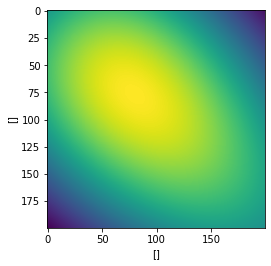

In [56]:
cnf_density(model)

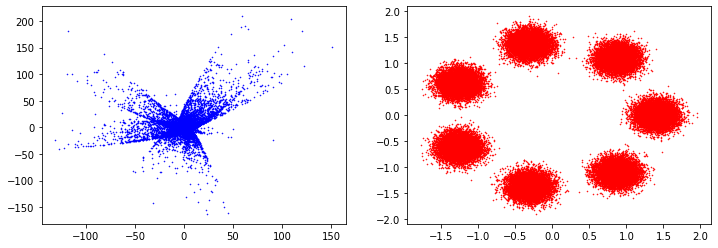

In [122]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(new_x[:,1], new_x[:,2], s=0.3, c='blue')
#plt.scatter(boh[:,0], boh[:,1], s=0.3, c='black')

plt.subplot(122)
plt.scatter(X[:,0], X[:,1], s=0.3, c='red')

In [8]:
def plot_samples():
    sample = prior.sample(torch.Size([1 << 13]))
    # integrating from 1 to 0
    model[1].s_span = torch.linspace(1, 0, 2)
    new_x = model(sample).cpu().detach()
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.scatter(new_x[:,1], new_x[:,2], s=2.3, alpha=0.2, linewidths=0.1, c='blue', edgecolors='black')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

    plt.subplot(122)
    plt.scatter(X[:,0], X[:,1], s=5.3, alpha=0.2, c='red',  linewidths=0.1, edgecolors='black')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    model[1].s_span = torch.linspace(0, 1, 2)

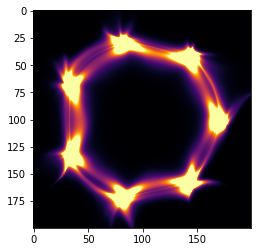

In [69]:
def cnf_density(model):
    with torch.no_grad():
        npts = 200
        side = np.linspace(-2., 2., npts)
        xx, yy = np.meshgrid(side, side)
        memory= 100

        x = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])
        x = torch.from_numpy(x).type(torch.float32).to(device)

        z, delta_logp = [], []
        inds = torch.arange(0, x.shape[0]).to(torch.int64)
        for ii in torch.split(inds, int(memory**2)):
            z_full = model(x[ii]).cpu().detach()
            z_, delta_logp_ = z_full[:, 1:], z_full[:, 0]
            z.append(z_)
            delta_logp.append(delta_logp_)

        z = torch.cat(z, 0)
        delta_logp = torch.cat(delta_logp, 0)

        logpz = prior.log_prob(z.cuda()).cpu() # logp(z)
        logpx = logpz - delta_logp
        px = np.exp(logpx.cpu().numpy()).reshape(npts, npts)
        plt.imshow(px, cmap='inferno', vmax=px.mean());
a = cnf_density(model)       